Movie reviews obtained through the API for The Movie Database (TMDB) : https://developer.themoviedb.org

In [2]:
# imports
import requests
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd, numpy as np
import math
pd.set_option('display.max_rows', None) # show all rows
pd.set_option('display.max_colwidth', 10000) # show full width of columns

In [2]:
# variables
api_key = os.environ.get("API_KEY")
base_url = "https://api.themoviedb.org/3"

### Retrieving the data

In [3]:
# Store all movies currently playing into an array

# Each API call can display one page which corresponds to 20 results. 
# We can find the maximum number of pages when we make a single query at page 1, the total number of remaining pages is listed as the penultimate element of the results array.
def total_pages():

    pages=0
    
    params={
        "api_key": api_key,
        "page":1
        }
    response = requests.get(f"{base_url}/movie/now_playing", params=params)
    data = response.json()
    if response.status_code == 200:
        pages = data['total_pages'] + 1
        return pages
    else:
        print("Error", response.status_code, "\n", response.text)


# Let's define a function and specify the number of loops to be the maximum number of page.
def movie_list(page):
    
    movies =[]

    for i in range(1, page+1):
        params={
            "api_key": api_key,
            "page":i
            }
        response = requests.get(f"{base_url}/movie/now_playing", params=params)
        data = response.json()

        # Let's store the movie title and movie_ID into the movies array
        if response.status_code == 200:
            for movie in data['results']:
                movies.append({movie['title']: movie['id']})
        else:
            print("Error", response.status_code, "\n", response.text)
    return movies


# combine both functions and retrieve all movies currently playing
movies = movie_list(total_pages())

# display(movies)
# print(len(movies))

In [4]:
# Extract the reviews for each movie (as of march 2024, it's about 4000 movies, so the query can take a few minutes)

params = {"api_key": api_key}

def movie_reviews(movies):

    reviews =[]

    for m in movies:

        title = str(list(m.keys())[0])
        response = requests.get(f"{base_url}/movie/{list(m.values())[0]}/reviews", params=params)
        data = response.json()

        if ('results' in data) and (data['results']):   # if there is a 'results' array in the json file and if that array is not empty
            for review in data['results']:
                author = review.get('author', None)
                content = review.get('content', None)
                rating = review['author_details'].get('rating', np.nan)
                reviews.append([title, author, content, rating])

    return reviews

reviews = movie_reviews(movies)

In [18]:
# Store the result in a dataframe
df = pd.DataFrame(reviews)
df.columns=['movie_title','reviewer','review', 'rating_given']

# Export as bronze table
df.to_csv('exports/movie_reviews_bronze.csv', index=False) 

In [12]:
# Load the bronze table
df = pd.read_csv('exports/movie_reviews_bronze.csv')

# perform EDA on our new dataframe
display(df.head())
display(df.tail())
display(df.shape)
df.info()

# view null values
print('\nNumber of null values is :')
print(df.isna().sum())

# view number of duplicates
print('\nNumber of duplicates is:', df.duplicated().sum())


,movie_title,reviewer,review,rating_given
0,Kung Fu Panda 4,Chris Sawin,"_Kung Fu Panda 4_ isn’t the best _Kung Fu Panda_ film, or even the best of the series’ three sequels. However, as a fourth film in a franchise, it’s a ton of fun.\r\n\r\nAnd though it’s action isn’t quite as entertaining as its predecessors and it’s unfortunate to see Awkwafina playing yet another thief (_Jumanji: The Next Level_ says hello), for the most part, _Kung Fu Panda 4_ happily skadooshes its way to animated greatness.\r\n\r\n**Full review:** https://bit.ly/KuFuPa4",6.0
1,Damsel,thorian93,"Today I enjoyed: Damsel.\r\n\r\nDamsel is a Netflix Original, that was released just a few days ago. Starring a strong cast with Millie Bobby Brown, Robin Wright, Angela Bassett and the voice of Shohreh Aghdashloo it follows the odyssey of Elodie. I am not going to spoil the plot for you, but I bet you can foresee most developments, dear reader.\r\n\r\nOverall I have mixed feelings. The story is nothing new, most elements are well known for this kind of movie. Some decisions of characters (including the dragon) feel dumb, and sometimes our main character gets very lucky, so the rest of the plot can happen. The CGI ranges from poor to pretty good, poor more in the begging, with huge landscapes and castles, but later, when the dragon makes an appearance, it looks pretty decent. But I was watching on a rather small screen and Netflix is punishing me with mediocre quality for some time now. So take my visual rating with a grain of salt. Now one thing I will say about the dragon: It has an interesting spin to it. For one thing, half of the time, we do not really see it and only hear Shohreh Aghdashloo's deep, rasping voice, bringing it to life. And when we actually see the dragon, it has a slight horror touch if you will. It looks like a hybrid between your average majestic and broadly loved dragon and something more dark and slimy. A muskrat comes to mind. I liked that (sort of).\r\n\r\nOne remark towards the title: While it is obviously a play the well known 'Damsel in distress' and obviously Elodie fights instead of needing to be rescued, she screams a lot and actually seems in distress half of the film. Until she suddenly becomes the hero and single-handedly fights the dragon. It is a bit much and hard to believe.\r\n\r\nThis is in all honesty an average movie. It is neither terrible nor great. If you are in the mood for some imagery, gold and jewels, dragons, princesses, and a few swords, then go for it. There are worse ways to spend roughly 109 minutes. But there are also better ways.\r\n\r\n_Originally posted on my blog: https://robingierse.de/blog/tie-damsel._",6.5
2,Damsel,Manuel São Bento,"FULL SPOILER-FREE REVIEW @ https://talkingfilms.net/damsel-review-a-generic-yet-immersive-fantasy-flick/\r\n\r\n""Damsel attempts to deliver a tale of empowerment and adventure within the rich fantasy genre but finds itself entangled in the ropes of predictability and missed opportunities for deeper narrative innovation.\r\n\r\nDespite its shortcomings, the film shines through its technical prowess, from visually stunning effects to immersive world-building, and is anchored by Millie Bobby Brown’s compelling lead performance.\r\n\r\nWhile it may not redefine its genre or leave an indelible mark on the history of cinema, it’s a pleasant home viewing with moments of genuine charm and resilience.""\r\n\r\nRating: B-",6.0
3,No Way Up,OrlyForly,"Terrible Script, dialogue, directing, hammy editing. Music is meh. Poor acting (but they clearly got no support). This crap show's the contempt producers like this have for the audience that gives them money. The writer, director, producers and editor must have been so full of ego that I bet continues today, despite the poor reviews. During the boring minutes (90) I drifted off imagining them all working on these scenes thinking they were amazing, and trying to understand the level of narcissism required. Just delusional film makers t

,movie_title,reviewer,review,rating_given
419,Séance Games - Metaxu,MayaRamirez,Incredible Gen Z horror movie! I enjoyed every second. The pacing is on point. The acting is top notch. The production is perfection. The special effects are realistic yet imaginative. The storyline is relatable and intriguing. It mimics a classic murder mystery while encapsulating a horrific tragedy. Tane McClure did a phenomenal job directing. I am impressed and mesmerized. Definitely check it out!,10.0
420,Bag of Patience,notprasun_,"The mind of Sameer Rai fascinates me, and this is coming from someone who just watched Poor Things like an hour ago.",NaN
421,The Seven Seas of Sage,thecabbageboy,"The film is a celebration of the inherent dramatism and queerness of Southeast Asia history, as well as a wonderful exploration of the trope of found family. The characters are hilarious, complex and so well-explored within a short runtime; at first glance, the titular character (as advertised) is a silly babygirl, and over time, we get to see the nuance in every interaction! The dynamics are absolutely insane, everybody is so different and yet, their relationships manage to bring out the best in each other. Overall, fantastic writing, amazing creative direction, 100/10 would recommend",NaN
422,Dirty Vote,yahyaharyantoo,"go deeper into the schemes of the ruling power,\r\n\r\nI just found out about the partition of the province of Papua from this movie, and it was also used for votes. horrifying.\r\nlet's vote wisely, https://www.bijakmemilih.id/en/",8.0
423,Vice News Presents: Mass Shooting America,reelfilmophile,Tragically relevant…praying for Kansas City right now,7.0


(424, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_title   424 non-null    object 
 1   reviewer      424 non-null    object 
 2   review        424 non-null    object 
 3   rating_given  397 non-null    float64
dtypes: float64(1), object(3)
memory usage: 13.4+ KB

Number of null values is :
movie_title      0
reviewer         0
review           0
rating_given    27
dtype: int64

Number of duplicates is: 3


In [8]:
# removing unwanted characters from the review texts
df2 = df.copy()
df2['review'].replace(['\n','\r', '@', '_', '\*'], '', regex=True, inplace=True)
df2['review']=df2['review']

# display(df2[['review']])

In [9]:
# view the duplicates
display(df2[df2.duplicated(subset='review', keep=False)])

# drop the duplicates
df2.drop_duplicates(inplace=True)

# view the new shape
display(df2.shape)

# Export as silver table
df2.to_csv('exports/movie_reviews_silver.csv', index=False) 

,movie_title,reviewer,review,rating_given
164,The Holdovers,Brent Marchant,"Heartwarming films for the holidays are something we’re all supposed to love, right? Well, if you’re talking about the works of directors like Frank Capra, George Seaton, Michael Curtiz and Chris Columbus, you’d be correct. But, since it’s been so long since we’ve had releases of that quality, in recent years, viewers hungry for such movies have been glomming on to anything that even remotely approaches such titles, whether or not the accolades are deserved. And that, in my view, sums up my feelings on the much-celebrated new feature from director Alexander Payne. This tale of a curmudgeonly, condescending, middle-aged, fuss-budget prep school teacher (Paul Giamatti) assigned to babysit a group of rambunctious students who are unable to be with their families for the year-end holidays has a premise with considerable potential that, unfortunately, is squandered by a narrative that feels loosely stitched together and ultimately comes across as patently undercooked. Indeed, what could have been a fun-filled romp a la a Christmastime take on movies like “Dead Poets Society” (1989), regrettably, comes up decidedly short. Admittedly, the film has its share of modestly funny and warm, fuzzy moments, but many of the scenes don’t flow smoothly from one to the next, creating a storyline that feels forced without delivering the goods to make a release like this work. While it’s true that the film succeeds (surprisingly) at depicting the mostly one-dimensional characters’ requisite personal evolution over the course of the picture, that almost-accidental accomplishment is seriously overshadowed by a series of plot elements that largely feel thrown together, incorporated without a terribly great amount of thought and an undeniable lack of cohesiveness. And, to be honest, the picture’s most interesting character is the academy’s chief cook (Da’Vine Joy Randolph), whose richly layered persona (and deftly nuanced performance) runs circles around those of its other two principals (Giamatti and Dominic Sessa as one of the stranded students). It’s disappointing that a director as talented as Alexander Payne has churned out a project as half-baked as this one is (particularly one that comes across as self-satisfied with itself as this offering often does) when compared to previous titles like “Nebraska” (2013) and “The Descendants” (2011). And would-be viewers should be wary of many of the inflated claims and awards season buzz being showered on this offering. But, in an age in which moviegoers are looking for pictures that provide the kind of holiday cinema comfort they so desperately crave, it’s understandable that such viewers might be drawn to a film like this. It’s just such a shame that they won’t find what they’re looking for in this one.",6.0
165,The Holdovers,Brent Marchant,"Heartwarming films for the holidays are something we’re all supposed to love, right? Well, if you’re talking about the works of directors like Frank Capra, George Seaton, Michael Curtiz and Chris Columbus, you’d be correct. But, since it’s been so long since we’ve had releases of that quality, in recent years, viewers hungry for such movies have been glomming on to anything that even remotely approaches such titles, whether or not the accolades are deserved. And that, in my view, sums up my feelings on the much-celebrated new feature from director Alexander Payne. This tale of a curmudgeonly, condescending, middle-aged, fuss-budget prep school teacher (Paul Giamatti) assigned to babysit a group of rambunctious students who are unable to be with their families for the year-end holidays has a premise with considerable potential that, unfortunately, is squandered by a narrative that feels loosely stitched together and ultimately comes across as patently undercooked. Indeed, what could have been a fun-filled romp a la a Christmastime take on movies like “Dead Poets Society” (1989), regrettably, c

(421, 4)

Out of almost 4000 movies, we only have about 10% of that as reviews.

### Sentiment Analysis with TextBlob
Doc : https://textblob.readthedocs.io/en/dev/


In [70]:
# Load the silver table
df = pd.read_csv('exports/movie_reviews_silver.csv')

In [88]:
# First, let's convert the given rating to a sentiment
# Having taken a look at the data, I think it's fair to assume that if the actual rating is above 6, it's positive; below 5 is negative, and anything else that's not N/A is neutral.

def sentiment(rating):
    if rating > 6:
        return 'positive'
    elif rating <5:
        return 'negative'
    elif math.isnan(rating):
        return np.nan
    else:
        return 'neutral'

# Create a new column on our dataframe that will be the result of the function applied on the 'review' column
df['sentiment'] = df['rating_given'].apply(sentiment)

# display(df2.head())
# display(df2.tail())
# display(df2['sentiment'].unique())

In [22]:
# %pip install textblob

In [89]:
# Now let's perform sentiment analysis on the 'review' column using TextBlob

from textblob import TextBlob

# Create a new function that can be applied on a dataframe column
def textblob_sentiment(text):
    blob = TextBlob(text)
    score = blob.sentiment.polarity
    if score > 0:
        return 'positive'
    elif score <0:
        return 'negative'
    else:
        return 'neutral'

# Create a new column on our dataframe that will be the result of the function applied on the 'review' column
df['textblob_sentiments'] = df['review'].apply(textblob_sentiment)

display(df.head())
display(df.tail())

,movie_title,reviewer,review,rating_given,sentiment,textblob_sentiments,vader_sentiments
0,Kung Fu Panda 4,Chris Sawin,"Kung Fu Panda 4 isn’t the best Kung Fu Panda film, or even the best of the series’ three sequels. However, as a fourth film in a franchise, it’s a ton of fun.And though it’s action isn’t quite as entertaining as its predecessors and it’s unfortunate to see Awkwafina playing yet another thief (Jumanji: The Next Level says hello), for the most part, Kung Fu Panda 4 happily skadooshes its way to animated greatness.Full review: https://bit.ly/KuFuPa4",6.0,neutral,positive,negative
1,Damsel,thorian93,"Today I enjoyed: Damsel.Damsel is a Netflix Original, that was released just a few days ago. Starring a strong cast with Millie Bobby Brown, Robin Wright, Angela Bassett and the voice of Shohreh Aghdashloo it follows the odyssey of Elodie. I am not going to spoil the plot for you, but I bet you can foresee most developments, dear reader.Overall I have mixed feelings. The story is nothing new, most elements are well known for this kind of movie. Some decisions of characters (including the dragon) feel dumb, and sometimes our main character gets very lucky, so the rest of the plot can happen. The CGI ranges from poor to pretty good, poor more in the begging, with huge landscapes and castles, but later, when the dragon makes an appearance, it looks pretty decent. But I was watching on a rather small screen and Netflix is punishing me with mediocre quality for some time now. So take my visual rating with a grain of salt. Now one thing I will say about the dragon: It has an interesting spin to it. For one thing, half of the time, we do not really see it and only hear Shohreh Aghdashloo's deep, rasping voice, bringing it to life. And when we actually see the dragon, it has a slight horror touch if you will. It looks like a hybrid between your average majestic and broadly loved dragon and something more dark and slimy. A muskrat comes to mind. I liked that (sort of).One remark towards the title: While it is obviously a play the well known 'Damsel in distress' and obviously Elodie fights instead of needing to be rescued, she screams a lot and actually seems in distress half of the film. Until she suddenly becomes the hero and single-handedly fights the dragon. It is a bit much and hard to believe.This is in all honesty an average movie. It is neither terrible nor great. If you are in the mood for some imagery, gold and jewels, dragons, princesses, and a few swords, then go for it. There are worse ways to spend roughly 109 minutes. But there are also better ways.Originally posted on my blog: https://robingierse.de/blog/tie-damsel.",6.5,positive,positive,positive
2,Damsel,Manuel São Bento,"FULL SPOILER-FREE REVIEW https://talkingfilms.net/damsel-review-a-generic-yet-immersive-fantasy-flick/""Damsel attempts to deliver a tale of empowerment and adventure within the rich fantasy genre but finds itself entangled in the ropes of predictability and missed opportunities for deeper narrative innovation.Despite its shortcomings, the film shines through its technical prowess, from visually stunning effects to immersive world-building, and is anchored by Millie Bobby Brown’s compelling lead performance.While it may not redefine its genre or leave an indelible mark on the history of cinema, it’s a pleasant home viewing with moments of genuine charm and resilience.""Rating: B-",6.0,neutral,positive,positive
3,No Way Up,OrlyForly,"Terrible Script, dialogue, directing, hammy editing. Music is meh. Poor acting (but they clearly got no support). This crap show's the contempt producers like this have for the audience that gives them money. The writer, director, producers and editor must have been so full of ego that I bet continues today, despite the poor reviews. During the boring minutes (90) I drifted off imagining them all working on these scenes thinking they were amazing, and trying to understand the level of narcissism required. Just de

,movie_title,reviewer,review,rating_given,sentiment,textblob_sentiments,vader_sentiments
416,Séance Games - Metaxu,MayaRamirez,Incredible Gen Z horror movie! I enjoyed every second. The pacing is on point. The acting is top notch. The production is perfection. The special effects are realistic yet imaginative. The storyline is relatable and intriguing. It mimics a classic murder mystery while encapsulating a horrific tragedy. Tane McClure did a phenomenal job directing. I am impressed and mesmerized. Definitely check it out!,10.000000,positive,positive,negative
417,Bag of Patience,notprasun_,"The mind of Sameer Rai fascinates me, and this is coming from someone who just watched Poor Things like an hour ago.",3.000000,negative,negative,positive
418,The Seven Seas of Sage,thecabbageboy,"The film is a celebration of the inherent dramatism and queerness of Southeast Asia history, as well as a wonderful exploration of the trope of found family. The characters are hilarious, complex and so well-explored within a short runtime; at first glance, the titular character (as advertised) is a silly babygirl, and over time, we get to see the nuance in every interaction! The dynamics are absolutely insane, everybody is so different and yet, their relationships manage to bring out the best in each other. Overall, fantastic writing, amazing creative direction, 100/10 would recommend",7.407855,positive,positive,positive
419,Dirty Vote,yahyaharyantoo,"go deeper into the schemes of the ruling power,I just found out about the partition of the province of Papua from this movie, and it was also used for votes. horrifying.let's vote wisely, https://www.bijakmemilih.id/en/",8.000000,positive,positive,positive
420,Vice News Presents: Mass Shooting America,reelfilmophile,Tragically relevant…praying for Kansas City right now,7.000000,positive,positive,negative


### Sentiment Analysis with Vader from NLTK (Natural Language Toolkit)

Doc : https://www.nltk.org/   
Example use case : https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e

In [24]:
# %pip install nltk
# nltk.download('vader_lexicon')

Vader results :  
neg: the negative sentiment score (between 0 and 1)  
neu: the neutral sentiment score (between 0 and 1)  
pos: the positive sentiment score (between 0 and 1)  
compound: the overall sentiment score (between -1 and 1)

In [90]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

sentiments =[]

# Loop through the reviews and analyze the sentiment
for text in df['review']:
    sentiment = analyzer.polarity_scores(text)['compound']
    if sentiment >0:
        sentiments.append('positive')

    elif sentiment <0:
        sentiments.append('negative')
    else:
        sentiments.append('neutral')

df['vader_sentiments'] = sentiments

display(df.head())
display(df.tail())


,movie_title,reviewer,review,rating_given,sentiment,textblob_sentiments,vader_sentiments
0,Kung Fu Panda 4,Chris Sawin,"Kung Fu Panda 4 isn’t the best Kung Fu Panda film, or even the best of the series’ three sequels. However, as a fourth film in a franchise, it’s a ton of fun.And though it’s action isn’t quite as entertaining as its predecessors and it’s unfortunate to see Awkwafina playing yet another thief (Jumanji: The Next Level says hello), for the most part, Kung Fu Panda 4 happily skadooshes its way to animated greatness.Full review: https://bit.ly/KuFuPa4",6.0,neutral,positive,negative
1,Damsel,thorian93,"Today I enjoyed: Damsel.Damsel is a Netflix Original, that was released just a few days ago. Starring a strong cast with Millie Bobby Brown, Robin Wright, Angela Bassett and the voice of Shohreh Aghdashloo it follows the odyssey of Elodie. I am not going to spoil the plot for you, but I bet you can foresee most developments, dear reader.Overall I have mixed feelings. The story is nothing new, most elements are well known for this kind of movie. Some decisions of characters (including the dragon) feel dumb, and sometimes our main character gets very lucky, so the rest of the plot can happen. The CGI ranges from poor to pretty good, poor more in the begging, with huge landscapes and castles, but later, when the dragon makes an appearance, it looks pretty decent. But I was watching on a rather small screen and Netflix is punishing me with mediocre quality for some time now. So take my visual rating with a grain of salt. Now one thing I will say about the dragon: It has an interesting spin to it. For one thing, half of the time, we do not really see it and only hear Shohreh Aghdashloo's deep, rasping voice, bringing it to life. And when we actually see the dragon, it has a slight horror touch if you will. It looks like a hybrid between your average majestic and broadly loved dragon and something more dark and slimy. A muskrat comes to mind. I liked that (sort of).One remark towards the title: While it is obviously a play the well known 'Damsel in distress' and obviously Elodie fights instead of needing to be rescued, she screams a lot and actually seems in distress half of the film. Until she suddenly becomes the hero and single-handedly fights the dragon. It is a bit much and hard to believe.This is in all honesty an average movie. It is neither terrible nor great. If you are in the mood for some imagery, gold and jewels, dragons, princesses, and a few swords, then go for it. There are worse ways to spend roughly 109 minutes. But there are also better ways.Originally posted on my blog: https://robingierse.de/blog/tie-damsel.",6.5,positive,positive,positive
2,Damsel,Manuel São Bento,"FULL SPOILER-FREE REVIEW https://talkingfilms.net/damsel-review-a-generic-yet-immersive-fantasy-flick/""Damsel attempts to deliver a tale of empowerment and adventure within the rich fantasy genre but finds itself entangled in the ropes of predictability and missed opportunities for deeper narrative innovation.Despite its shortcomings, the film shines through its technical prowess, from visually stunning effects to immersive world-building, and is anchored by Millie Bobby Brown’s compelling lead performance.While it may not redefine its genre or leave an indelible mark on the history of cinema, it’s a pleasant home viewing with moments of genuine charm and resilience.""Rating: B-",6.0,neutral,positive,positive
3,No Way Up,OrlyForly,"Terrible Script, dialogue, directing, hammy editing. Music is meh. Poor acting (but they clearly got no support). This crap show's the contempt producers like this have for the audience that gives them money. The writer, director, producers and editor must have been so full of ego that I bet continues today, despite the poor reviews. During the boring minutes (90) I drifted off imagining them all working on these scenes thinking they were amazing, and trying to understand the level of narcissism required. Just de

,movie_title,reviewer,review,rating_given,sentiment,textblob_sentiments,vader_sentiments
416,Séance Games - Metaxu,MayaRamirez,Incredible Gen Z horror movie! I enjoyed every second. The pacing is on point. The acting is top notch. The production is perfection. The special effects are realistic yet imaginative. The storyline is relatable and intriguing. It mimics a classic murder mystery while encapsulating a horrific tragedy. Tane McClure did a phenomenal job directing. I am impressed and mesmerized. Definitely check it out!,10.000000,positive,positive,negative
417,Bag of Patience,notprasun_,"The mind of Sameer Rai fascinates me, and this is coming from someone who just watched Poor Things like an hour ago.",3.000000,negative,negative,positive
418,The Seven Seas of Sage,thecabbageboy,"The film is a celebration of the inherent dramatism and queerness of Southeast Asia history, as well as a wonderful exploration of the trope of found family. The characters are hilarious, complex and so well-explored within a short runtime; at first glance, the titular character (as advertised) is a silly babygirl, and over time, we get to see the nuance in every interaction! The dynamics are absolutely insane, everybody is so different and yet, their relationships manage to bring out the best in each other. Overall, fantastic writing, amazing creative direction, 100/10 would recommend",7.407855,positive,positive,positive
419,Dirty Vote,yahyaharyantoo,"go deeper into the schemes of the ruling power,I just found out about the partition of the province of Papua from this movie, and it was also used for votes. horrifying.let's vote wisely, https://www.bijakmemilih.id/en/",8.000000,positive,positive,positive
420,Vice News Presents: Mass Shooting America,reelfilmophile,Tragically relevant…praying for Kansas City right now,7.000000,positive,positive,negative


In [92]:
# Now let's compare both models and see which one has more matches with the actual sentiment based on the rating

blob_result = 0
vader_result = 0

for actual, blob, vader in zip(df['sentiment'], df['textblob_sentiments'], df['vader_sentiments']):
    if blob == actual:
        blob_result +=1
    if vader == actual:
        vader_result+=1

print('Accuracy for TextBlob: ', blob_result/df.shape[0])
print('Accuracy for Vader NLTK: ', vader_result/df.shape[0])

Accuracy for TextBlob:  0.6270783847980997
Accuracy for Vader NLTK:  0.5629453681710214


The Textblob model seems better with a higher accuracy. Not a definitive conclusion since users can give ratings that don't necessarily match the sentiment of their review.  
We could use the result of this model to programmatically fill the missing rating values.

In [93]:
# Export current dataframe as silver2 table
df.to_csv('exports/movie_reviews_silver2.csv', index=False) 

In [94]:
# load silver2 table
df = pd.read_csv('exports/movie_reviews_silver2.csv')
df.head()

,movie_title,reviewer,review,rating_given,sentiment,textblob_sentiments,vader_sentiments
0,Kung Fu Panda 4,Chris Sawin,"Kung Fu Panda 4 isn’t the best Kung Fu Panda film, or even the best of the series’ three sequels. However, as a fourth film in a franchise, it’s a ton of fun.And though it’s action isn’t quite as entertaining as its predecessors and it’s unfortunate to see Awkwafina playing yet another thief (Jumanji: The Next Level says hello), for the most part, Kung Fu Panda 4 happily skadooshes its way to animated greatness.Full review: https://bit.ly/KuFuPa4",6.0,neutral,positive,negative
1,Damsel,thorian93,"Today I enjoyed: Damsel.Damsel is a Netflix Original, that was released just a few days ago. Starring a strong cast with Millie Bobby Brown, Robin Wright, Angela Bassett and the voice of Shohreh Aghdashloo it follows the odyssey of Elodie. I am not going to spoil the plot for you, but I bet you can foresee most developments, dear reader.Overall I have mixed feelings. The story is nothing new, most elements are well known for this kind of movie. Some decisions of characters (including the dragon) feel dumb, and sometimes our main character gets very lucky, so the rest of the plot can happen. The CGI ranges from poor to pretty good, poor more in the begging, with huge landscapes and castles, but later, when the dragon makes an appearance, it looks pretty decent. But I was watching on a rather small screen and Netflix is punishing me with mediocre quality for some time now. So take my visual rating with a grain of salt. Now one thing I will say about the dragon: It has an interesting spin to it. For one thing, half of the time, we do not really see it and only hear Shohreh Aghdashloo's deep, rasping voice, bringing it to life. And when we actually see the dragon, it has a slight horror touch if you will. It looks like a hybrid between your average majestic and broadly loved dragon and something more dark and slimy. A muskrat comes to mind. I liked that (sort of).One remark towards the title: While it is obviously a play the well known 'Damsel in distress' and obviously Elodie fights instead of needing to be rescued, she screams a lot and actually seems in distress half of the film. Until she suddenly becomes the hero and single-handedly fights the dragon. It is a bit much and hard to believe.This is in all honesty an average movie. It is neither terrible nor great. If you are in the mood for some imagery, gold and jewels, dragons, princesses, and a few swords, then go for it. There are worse ways to spend roughly 109 minutes. But there are also better ways.Originally posted on my blog: https://robingierse.de/blog/tie-damsel.",6.5,positive,positive,positive
2,Damsel,Manuel São Bento,"FULL SPOILER-FREE REVIEW https://talkingfilms.net/damsel-review-a-generic-yet-immersive-fantasy-flick/""Damsel attempts to deliver a tale of empowerment and adventure within the rich fantasy genre but finds itself entangled in the ropes of predictability and missed opportunities for deeper narrative innovation.Despite its shortcomings, the film shines through its technical prowess, from visually stunning effects to immersive world-building, and is anchored by Millie Bobby Brown’s compelling lead performance.While it may not redefine its genre or leave an indelible mark on the history of cinema, it’s a pleasant home viewing with moments of genuine charm and resilience.""Rating: B-",6.0,neutral,positive,positive
3,No Way Up,OrlyForly,"Terrible Script, dialogue, directing, hammy editing. Music is meh. Poor acting (but they clearly got no support). This crap show's the contempt producers like this have for the audience that gives them money. The writer, director, producers and editor must have been so full of ego that I bet continues today, despite the poor reviews. During the boring minutes (90) I drifted off imagining them all working on these scenes thinking they were amazing, and trying to understand the level of narcissism required. Just de

In [95]:
# find the mean of positive ratings and the mean of negative ratings
positive_mean = df['rating_given'][df['rating_given'] > 6].mean()
negative_mean = df['rating_given'][df['rating_given'] < 5].mean()

# create a function to replace missing ratings based on predicted sentiments
def fill_missing(row):
    if pd.isna(row['sentiment']):
        if row['textblob_sentiments'] =='positive':
            row['rating_given'] = positive_mean
            row['sentiment'] ='positive'
        elif row['textblob_sentiments'] =='negative':
            row['rating_given'] = negative_mean
            row['sentiment'] ='negative'
        else:
            row['rating_given'] = 5.0
            row['sentiment'] ='neutral'
    return row

# apply the function
df = df.apply(fill_missing, axis=1)

# verify that all NaN are replaced
display(df['rating_given'].isna().sum())
display(df['sentiment'].isna().sum())


0

0

In [98]:
# Export as gold table
df.to_csv('exports/movie_reviews_gold.csv')

### Visualizing the data with filled values

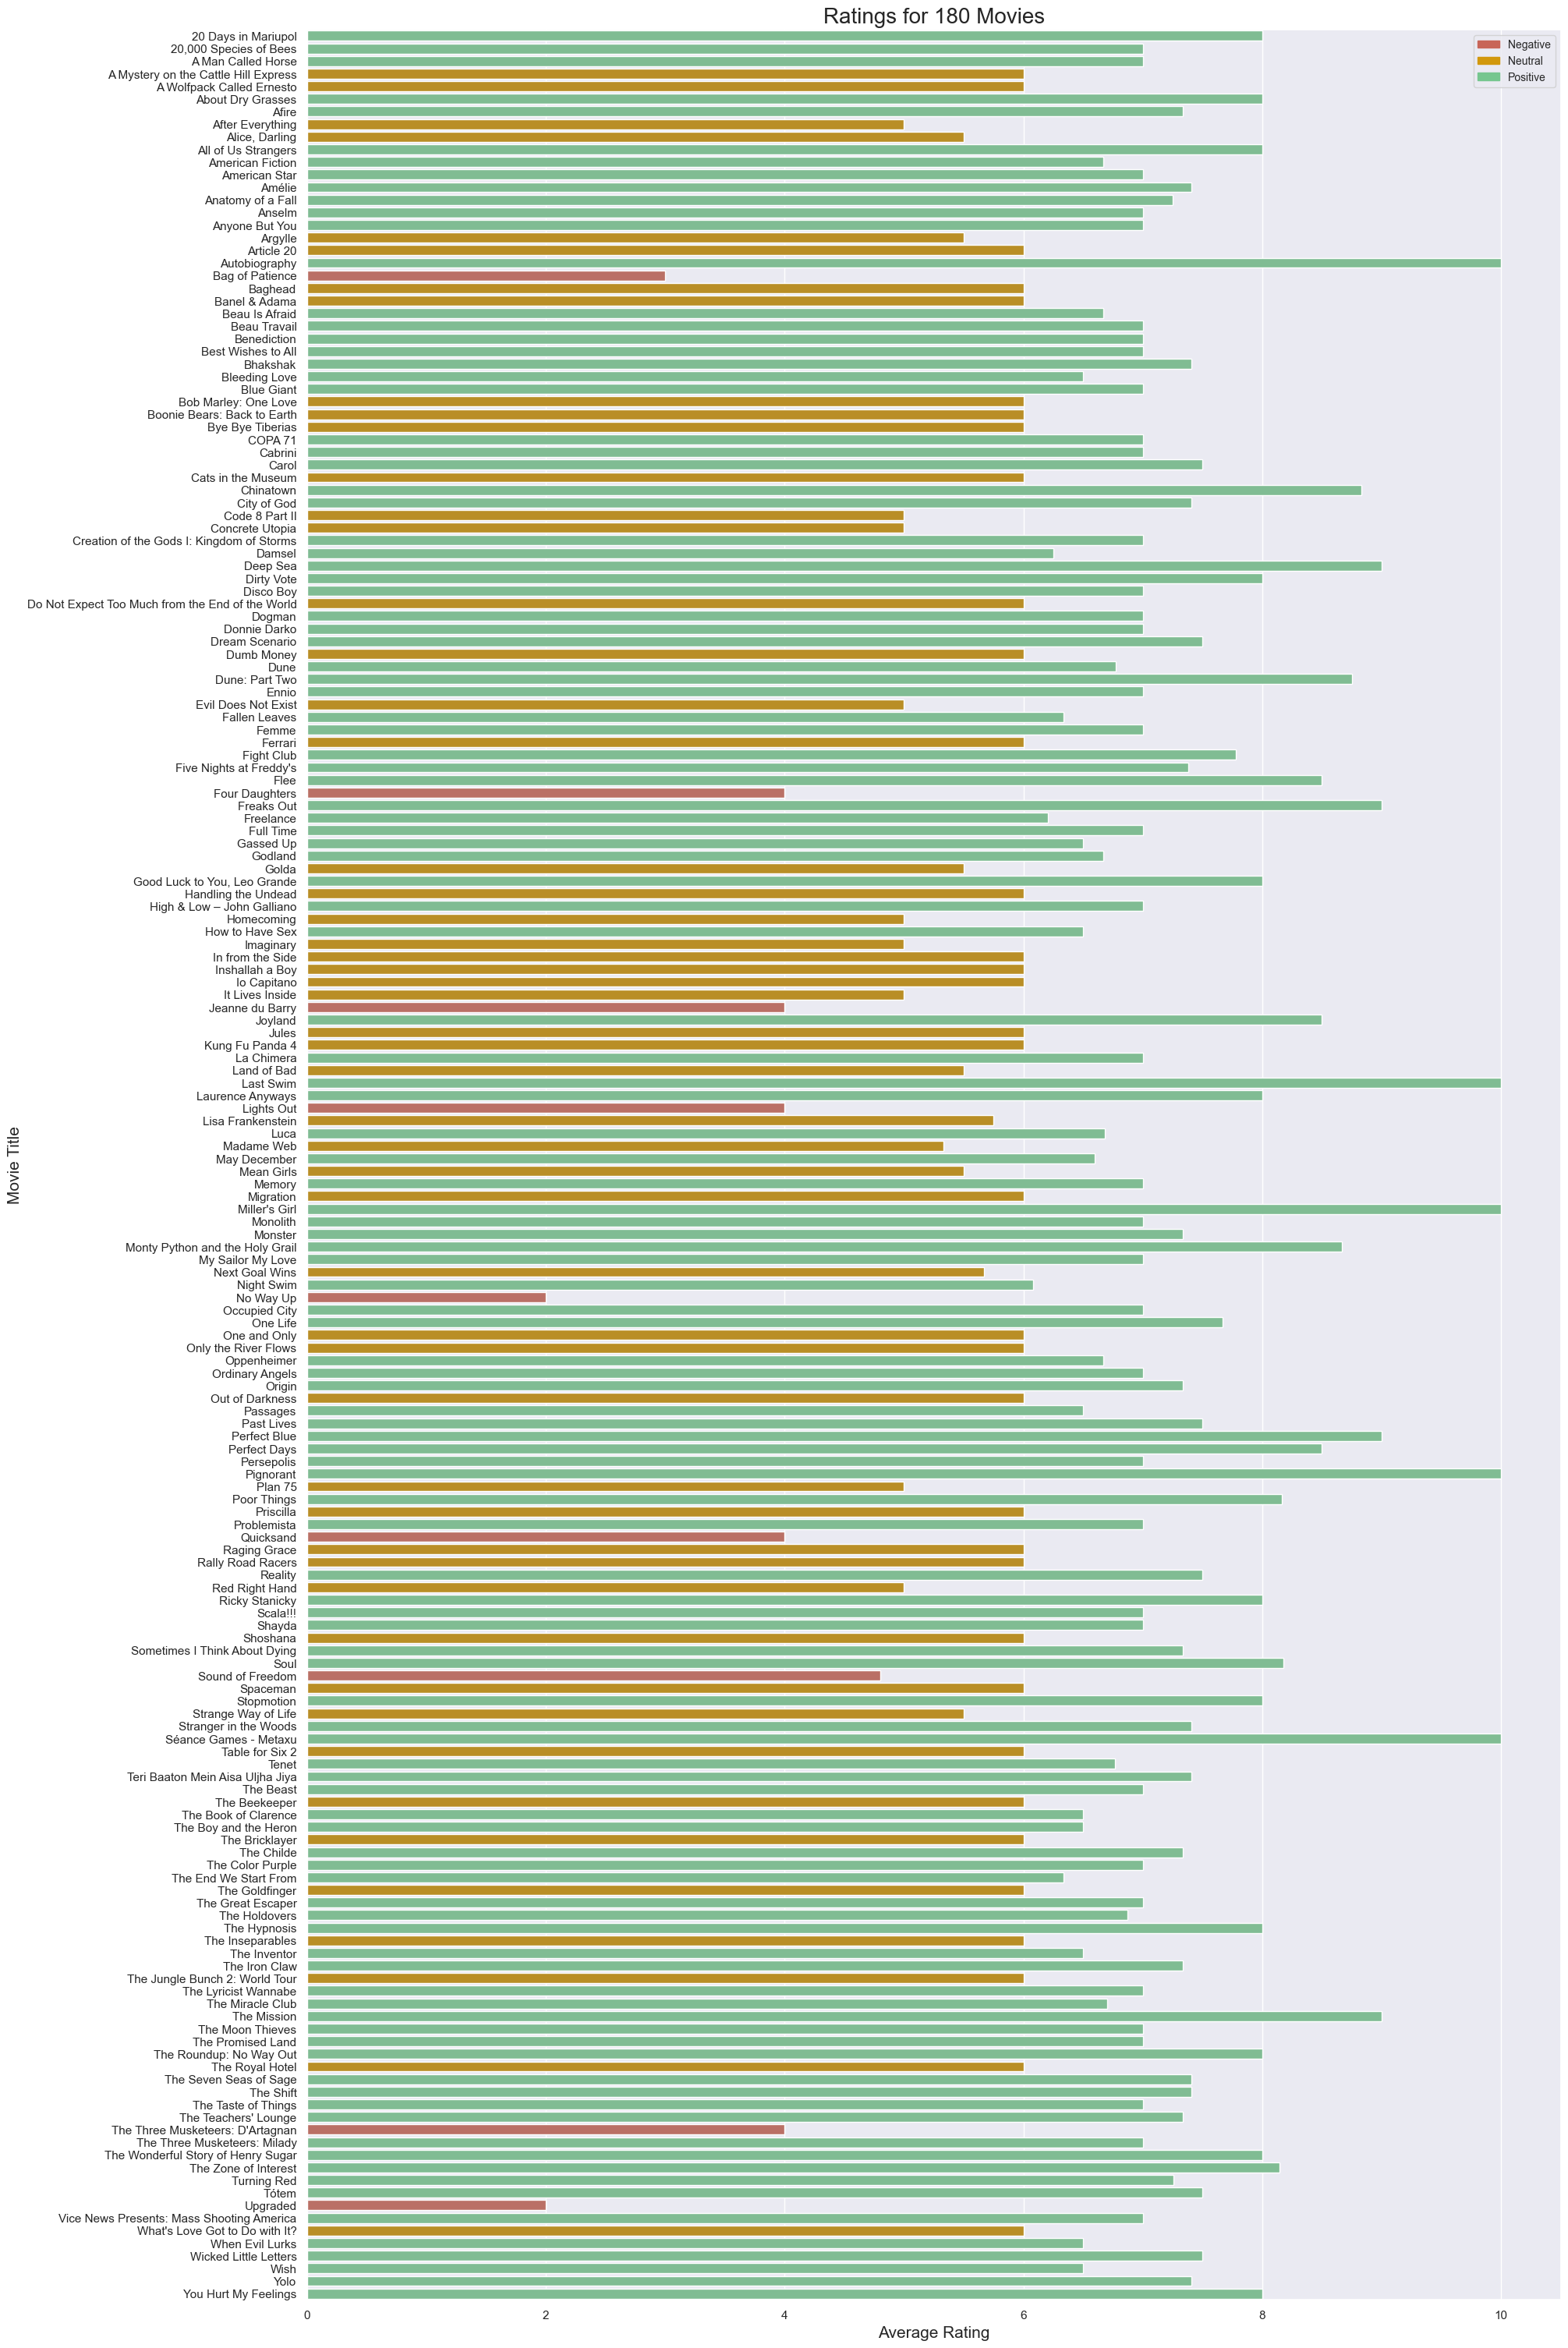

In [7]:
# Load the gold table
df= pd.read_csv('exports/movie_reviews_gold.csv')


# Let's plot the ratings VS movie_title 
df_ratings = df.groupby('movie_title', as_index=False).agg({'rating_given': 'mean'})
colors = np.where(df_ratings['rating_given'] < 5, '#c86558', np.where(df_ratings['rating_given'] > 6, "#76c68f", "#d2980d"))

count = df_ratings['movie_title'].nunique()

plt.figure(figsize=(20, 30), constrained_layout=True) 
sns.barplot(y=df_ratings['movie_title'].unique(), x=df_ratings['rating_given'], palette=colors, errorbar=None)
plt.ylabel('Movie Title', fontsize=15)
plt.xlabel('Average Rating', fontsize=15)
plt.title(f'Ratings for {count} Movies', fontsize=20)

legend_labels = ['Negative', 'Neutral', 'Positive']
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['#c86558', '#d2980d', '#76c68f']]
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize='small')

plt.show()